# Library

In [1]:
import os
import glob

import cv2
from PIL import Image

import numpy as np
import pandas as pd

import torch
import torchvision.transforms as transforms

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from utils.model import ConvNet

# EDA를 위한 DataFrame 생성

In [2]:
data = []
root_dir = './data/train/'

for class_dir in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_dir)
    for filename in os.listdir(class_path):
        data.append({'path': os.path.join(class_path, filename),
                     'class': class_dir})

In [3]:
df = pd.DataFrame(data)
df.head()

,path,class
0,./data/train/apple\201_100.jpg,apple
1,./data/train/apple\202_100.jpg,apple
2,./data/train/apple\203_100.jpg,apple
3,./data/train/apple\204_100.jpg,apple
4,./data/train/apple\205_100.jpg,apple


# EDA 시각화

## 분류 적합도 확인

In [4]:
n_cls = 5

# 모델 로드
model = ConvNet(num_classes=n_cls)
model.load_state_dict(torch.load("./checkpoints/conv_net.pth", map_location="cpu", weights_only=True))
model.eval()

# transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

features = []
labels = []

for idx, row in df.iterrows():
    img = Image.open(row['path']).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        _, feat = model(img_tensor)
        feat = feat.cpu().numpy().squeeze()

    features.append(feat)
    labels.append(row['class'])

X = np.vstack(features)
y = np.array(labels)

In [5]:
# KMeans
kmeans = KMeans(n_clusters=n_cls, random_state=42)
clusters = kmeans.fit_predict(X)

In [6]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

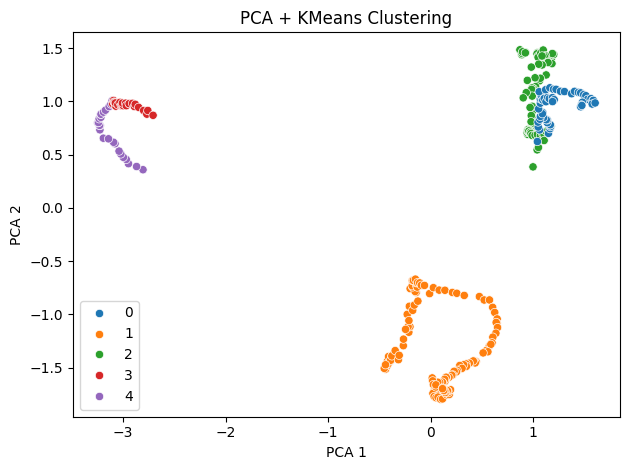

In [7]:
# KMeans 클러스터링 결과
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10', legend='full')
plt.title("PCA + KMeans Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

## 데이터 분포 확인
- "tomato" 클래스의 데이터 부족

In [8]:
df['class'].value_counts()

class
apple     127
cherry    127
tomato     50
Name: count, dtype: int64

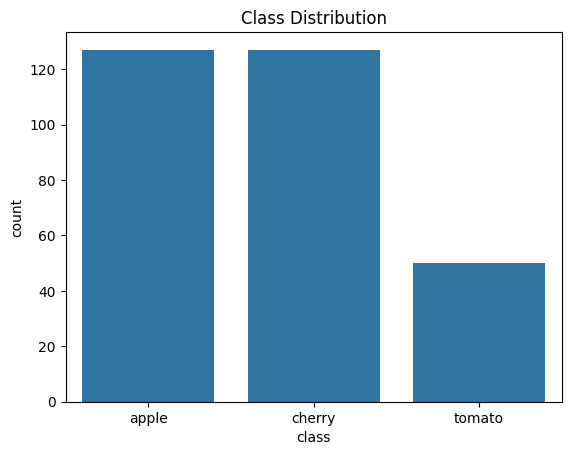

In [9]:
sns.countplot(x='class', data=df)
plt.title("Class Distribution")
plt.show()